In [ ]:
!pip install transformers
!pip install ijson

# Install OpenAI's CLIP model via GitHub — needed for extracting image embeddings using the CLIP model
!pip install git+https://github.com/openai/CLIP.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.0/135.0 kB 3.9 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-87eh0r9z
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-87eh0r9z
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
import random
import pickle

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import (
    AutoTokenizer,
    RobertaModel,
    Trainer,
    TrainingArguments,
    TrainerCallback,
    EarlyStoppingCallback
)

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, f1_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import clip
from PIL import Image


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = "/content/drive/MyDrive/TwiBot-22/TwiBot-22/"
load_dir = "/content/drive/MyDrive/TwiBot-22/prepared_data"

Mounted at /content/drive


In [ ]:
# Load saved data that was preprocessed earlier

# Load the list of user IDs selected for training/testing (sampled 50k–50k from each class)
with open(os.path.join(load_dir, "sampled_ids.pkl"), "rb") as f:
    sampled_ids = pickle.load(f)

# Load the user metadata as a pandas DataFrame (contains usernames, descriptions, numeric stats, etc.)
user_df = pd.read_pickle(os.path.join(load_dir, "user_df.pkl"))

# Load the dictionary mapping user IDs to ground-truth labels (0 = human, 1 = bot)
with open(os.path.join(load_dir, "label_dict.pkl"), "rb") as f:
    label_dict = pickle.load(f)

# Load the dictionary mapping user IDs to their cleaned tweet lists
with open(os.path.join(load_dir, "user_tweets.pkl"), "rb") as f:
    user_tweets = pickle.load(f)

# Load the list of sampled bot user IDs (after filtering + random sampling)
with open(os.path.join(load_dir, "sampled_bot_ids.pkl"), "rb") as f:
    sampled_bot_ids = pickle.load(f)

# Load the list of sampled human user IDs (after filtering + random sampling)
with open(os.path.join(load_dir, "sampled_human_ids.pkl"), "rb") as f:
    sampled_human_ids = pickle.load(f)

# Confirmation message
print("Loaded saved user data.")

Loaded saved user data.


In [ ]:
# Load CLIP model and preprocessing pipeline (ViT-B/32 = Vision Transformer Base, patch size 32x32)
device = "cuda" if torch.cuda.is_available() else "cpu"

model_clip, preprocess_clip = clip.load("ViT-B/32", device=device)

image_dir = "/content/drive/MyDrive/TwiBot-22/Images"
clip_features = {}

# Loop over each user in the dataset (user_df)
for idx, row in tqdm(user_df.iterrows(), total=len(user_df), desc="Extracting CLIP features"):

    user_id = row["id"]
    subfolder = f"{(idx // 10000) * 10000:06d}-{(idx // 10000) * 10000 + 9999:06d}"
    img_path = os.path.join(image_dir, subfolder, f"{idx}.jpg")

    # If the image file exists for this user, try to process it
    if os.path.exists(img_path):
        try:
            # Load the image, resize it to 224x224, normalize pixel values (turns the image into a PyTorch tensor of shape [3, 224, 224]) and add a batch dimension → shape becomes (1, 3, 224, 224)
            image = preprocess_clip(Image.open(img_path)).unsqueeze(0).to(device)

            # Pass the image through CLIP's vision encoder (ViT-B/32) to get a semantic feature vector
            with torch.no_grad():  # Disable gradients for speed and memory
                image_features = model_clip.encode_image(image).squeeze(0).cpu()  # Output shape: (512d)

            # Store the 512-dimensional vector in a dictionary under this user's ID
            clip_features[user_id] = image_features

        except:
            # Skip any image that is corrupted or cannot be opened
            pass

# After processing all users, save the dictionary to a .pt file
torch.save(clip_features, "/content/drive/MyDrive/TwiBot-22/clip_features.pt")

# This builds a dictionary like this:

# clip_features = {
#    "user1": tensor([...512 float values...]),
#    "user2": tensor([...512 float values...]),
#    ...
# }
# Each tensor represents the semantic features of the user’s profile image as computed by CLIP => and save this dictionary in clip_features.pt
# And Later in Training...
# load that file and use:
# clip_feature = self.clip_features.get(uid, torch.zeros(512))
# To get the corresponding image feature vector for each user. If it doesn't exist, we use a learnable embedding.

100%|███████████████████████████████████████| 338M/338M [00:23<00:00, 15.0MiB/s]
Extracting CLIP features:   1%|          | 747/100000 [02:42<4:32:19,  6.07it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Extracting CLIP features: 100%|██████████| 100000/100000 [4:12:33<00:00,  6.60it/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Manually create train/val/test split with 70/15/15 proportions per class (bot and human), with a fixed random_state.

# Custom 70/15/15 balanced split
from sklearn.model_selection import train_test_split

# Step 1: Split bots: -----------------------------------------------------------------------------------------
# bot_train: 70% of the sampled bots — for training
# bot_temp: 30% of the sampled bots — a temporary set that will later be split into validation and test sets.
bot_train, bot_temp = train_test_split(sampled_bot_ids, test_size=0.30, random_state=42)

# splitting the 30% bot_temp set into two equal parts:
# bot_val: 15% of original bots — for validation.
# bot_test: 15% of original bots — for testing.
bot_val, bot_test = train_test_split(bot_temp, test_size=0.5, random_state=42)

# Step 2: Split humans:same strategy for a balanced dataset ---------------------------------------------------
human_train, human_temp = train_test_split(sampled_human_ids, test_size=0.30, random_state=42)
human_val, human_test = train_test_split(human_temp, test_size=0.5, random_state=42)

# Step 3: Combine bot + human IDs for each split --------------------------------------------------------------
train_ids = bot_train + human_train
val_ids = bot_val + human_val
test_ids = bot_test + human_test

# Print sizes of each split
print(f"✅ Train IDs: {len(train_ids)}")
print(f"✅ Val IDs: {len(val_ids)}")
print(f"✅ Test IDs: {len(test_ids)}")

# Generate split_dict from your split
split_dict = {}
for uid in train_ids:
    split_dict[uid] = "train"
for uid in val_ids:
    split_dict[uid] = "val"
for uid in test_ids:
    split_dict[uid] = "test"

# Final check: Class distribution
from collections import Counter
print("🧪 Train label counts:", Counter([label_dict[uid] for uid in train_ids]))
print("🧪 Val label counts:", Counter([label_dict[uid] for uid in val_ids]))
print("🧪 Test label counts:", Counter([label_dict[uid] for uid in test_ids]))


✅ Train IDs: 70000
✅ Val IDs: 15000
✅ Test IDs: 15000
🧪 Train label counts: Counter({'bot': 35000, 'human': 35000})
🧪 Val label counts: Counter({'bot': 7500, 'human': 7500})
🧪 Test label counts: Counter({'bot': 7500, 'human': 7500})


In [ ]:
# Initialize tokenizer
# This loads the pre-trained RoBERTa tokenizer from HuggingFace's model hub.
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
# Custom PyTorch Dataset to load and prepare TwiBot user data for training
# For each user, it prepare textual data (username, description, and tweets) + numeric behavioral features (like follower-following ratio) + image features (precomputed CLIP embeddings of profile images)

class TwiBotDataset(Dataset):
    def __init__(self, user_ids, user_df, label_dict, user_tweets, clip_feature_path=None):
        self.user_ids = user_ids
        self.user_df = user_df.set_index('id')
        self.label_dict = label_dict
        self.user_tweets = user_tweets

        # Load precomputed CLIP features from file if path is given, else empty dict
        self.clip_features = torch.load(clip_feature_path) if clip_feature_path else {}

    def __len__(self):
        return len(self.user_ids)

    def __getitem__(self, idx):
        uid = self.user_ids[idx]

        # Sanity check: raise error if ID is missing from metadata or labels
        if uid not in self.user_df.index or uid not in self.label_dict:
            raise ValueError(f"Invalid user ID {uid}")

        # Get user metadata (username, description, numeric info)
        user_info = self.user_df.loc[uid]

        # Get list of tweets for this user (or empty list if missing)
        tweets = self.user_tweets.get(uid, [])

        # Combine profile-level text: username + description + tweets
        profile_text = user_info.get("username", "") + " " + user_info.get("description", "")
        tweets_text = " ".join(tweets)
        combined_text = profile_text + " " + tweets_text

        # Tokenize the full user text input for RoBERTa
        inputs = tokenizer(
            combined_text,
            truncation=True,
            padding='max_length',
            max_length=512,
            return_tensors="pt"
        )

        # Assign label (0 = human, 1 = bot)
        label = 1 if self.label_dict[uid] == "bot" else 0

        # Prepare numeric features (behavioral stats)
        numeric_features = torch.tensor([
            user_info.get('follower_following_ratio', 0.0),
            user_info.get('log_followers', 0.0),
            user_info.get('log_following', 0.0),
            user_info.get('log_tweet_count', 0.0)
        ], dtype=torch.float)

        # Load CLIP image feature for this user or fallback to zero vector if missing
        clip_feature = self.clip_features.get(uid, torch.zeros(512))

        # Return all tensors needed by the model
        return {
            'input_ids': inputs['input_ids'].squeeze(),             # Shape: (512,)
            'attention_mask': inputs['attention_mask'].squeeze(),   # Shape: (512,)
            'numeric_features': numeric_features,                   # Shape: (4,)
            'clip_features': clip_feature,                          # Shape: (512,)
            'labels': torch.tensor(label, dtype=torch.long)         # 0 or 1
        }

# ----------------------------------------------------------------------------------------

# Step 1: Precompute list of valid users (appear in both user_df and label_dict)
valid_user_ids = set(user_df['id']) & set(label_dict.keys())

# Step 2: Filter train/val/test splits to only include valid user IDs
valid_train_ids = [uid for uid in train_ids if uid in valid_user_ids]
valid_val_ids = [uid for uid in val_ids if uid in valid_user_ids]
valid_test_ids = [uid for uid in test_ids if uid in valid_user_ids]

# Step 3: Print stats about how many valid users were found
print(f"✅ Valid training IDs: {len(valid_train_ids)} / {len(train_ids)}")
print(f"✅ Valid validation IDs: {len(valid_val_ids)} / {len(val_ids)}")
print(f"✅ Valid test IDs: {len(valid_test_ids)} / {len(test_ids)}")

# Step 4: Create dataset objects for each split
clip_path = "/content/drive/MyDrive/TwiBot-22/clip_features.pt"  # path to saved CLIP features
train_dataset = TwiBotDataset(valid_train_ids, user_df, label_dict, user_tweets, clip_feature_path=clip_path)
val_dataset = TwiBotDataset(valid_val_ids, user_df, label_dict, user_tweets, clip_feature_path=clip_path)
test_dataset = TwiBotDataset(valid_test_ids, user_df, label_dict, user_tweets, clip_feature_path=clip_path)


✅ Valid training IDs: 70000 / 70000
✅ Valid validation IDs: 15000 / 15000
✅ Valid test IDs: 15000 / 15000


In [ ]:
# Compute dynamic class weights from training labels
train_labels = [sample['labels'].item() for sample in train_dataset]
class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)
print("Dynamic class weights:", class_weights)


Dynamic class weights: tensor([1., 1.])


In [ ]:
# Define the full multimodal model combining text, numeric, and image features

class RobertaWithNumericalFeaturesAndCLIP(nn.Module):
    def __init__(self, roberta_model_name='roberta-base', num_numeric_features=4, clip_feature_size=512):
        super().__init__()

        # Load pre-trained RoBERTa model to extract text features
        self.roberta = RobertaModel.from_pretrained(roberta_model_name)

        # Define a learnable fallback vector for users with missing CLIP image
        self.missing_clip_embedding = nn.Parameter(torch.zeros(clip_feature_size))  # Shape: (512,)
        nn.init.normal_(self.missing_clip_embedding, mean=0.0, std=0.02)  # Initialize it with small random values

        # Define a small neural network to compress RoBERTa output (768) to 256
        self.text_proj = nn.Sequential(
            nn.Linear(self.roberta.config.hidden_size, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        # Define a projection for 4 numeric features to 32-dim vector
        self.numeric_proj = nn.Sequential(
            nn.Linear(num_numeric_features, 32),
            nn.LayerNorm(32),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        # Define a projection for CLIP image features (512) to 128-dim vector
        self.clip_proj = nn.Sequential(
            nn.Linear(clip_feature_size, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        # Define fusion layers to combine all features (256+32+128=416 → 128)
        self.fusion = nn.Sequential(
            nn.Dropout(0.3),                  # Helps generalization
            nn.Linear(256 + 32 + 128, 256),   # First fusion layer
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 128),              # Reduce to final feature vector
            nn.ReLU()
        )

        # Final classification layer: 128 → 2 (human or bot)
        self.out = nn.Linear(128, 2)

    def forward(self, input_ids, attention_mask, numeric_features, clip_features, labels=None):
        # Ensure all inputs are on the same device (CPU or GPU)
        numeric_features = numeric_features.to(input_ids.device)
        clip_features = clip_features.to(input_ids.device)

        # Replace CLIP vectors that are all zeros with the learnable missing image embedding
        mask_missing = torch.all(clip_features == 0, dim=1)  # Detect which vectors are all-zero
        missing_embed = self.missing_clip_embedding.unsqueeze(0).repeat(clip_features.size(0), 1).to(input_ids.device)
        clip_features = torch.where(mask_missing.unsqueeze(1), missing_embed, clip_features)

        # Pass text through RoBERTa and extract the CLS token output (summary vector)
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # Extract first token (<s>) from each input sequence

        # Project each modality separately
        text_feat = self.text_proj(cls_output)             # Shape: (batch_size, 256)
        num_feat = self.numeric_proj(numeric_features)     # Shape: (batch_size, 32)
        clip_feat = self.clip_proj(clip_features)          # Shape: (batch_size, 128)

        # Concatenate all three features into one vector
        combined = torch.cat((text_feat, num_feat, clip_feat), dim=1)  # Shape: (batch_size, 416)

        # Fuse and reduce dimensions via fusion layers
        x = self.fusion(combined)  # Shape: (batch_size, 128)

        # Final classification to produce logits for [human, bot]
        logits = self.out(x)       # Shape: (batch_size, 2)

        # If labels are provided (training), compute cross-entropy loss
        if labels is not None:
            loss = nn.functional.cross_entropy(logits, labels)
            return {'loss': loss, 'logits': logits}

        # If labels not provided (inference), return logits only
        return {'logits': logits}

# Instantiate the model
model = RobertaWithNumericalFeaturesAndCLIP()

# Freeze RoBERTa's weights initially (only train other parts of the model first)
for param in model.roberta.parameters():
    param.requires_grad = False


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",                # Directory to save model checkpoints and results
    # evaluation_strategy="epoch",         # [DEPRECATED] Mistyped version — should be removed
    eval_strategy="epoch",                 # Evaluate the model at the end of each epoch
    learning_rate=3e-6,                    # Initial learning rate for the AdamW optimizer
    per_device_train_batch_size=8,         # Number of samples per GPU during training =>
                                                # Batch size = number of training samples processed at once before updating model weights.
                                                # Smaller batch = less GPU memory usage, but noisier gradients.
                                                # Larger batch = more stable gradients, but needs more RAM.
    per_device_eval_batch_size=8,          # Number of samples per GPU during evaluation
    num_train_epochs=7,                    # Number of full passes through the dataset => Later, use 3–5 epochs with the full dataset for final results.
                                                # An epoch is one full pass through the entire training dataset.
                                                # If you have 20,000 users in your dataset:
                                                # 1 epoch means the model sees all 20,000 once.
                                                # 2 epochs means the model sees them twice, learning more each time.
    warmup_ratio=0.1,                      # Helps stabilize training in early steps
    weight_decay=0.01,                     # Weight decay (L2 regularization) to prevent overfitting
    save_strategy="epoch",                 # Save model checkpoint at the end of every epoch
    logging_dir="./logs",                  # Directory for storing training logs (for TensorBoard or manual inspection)
    fp16=False,                            # enable if GPU supports it => The model uses 16-bit math where it's safe => and keeps 32-bit where needed (like in gradient updates) to preserve stability.
    logging_steps=10,                      # Log training loss etc. every 10 steps
    optim="adamw_torch",                   # Optional: Avoid fused optimizers that don't work on XLA
    report_to="none",                      # 🚫 disables wandb and all other reporters => # Disabling Weights & Biases (wandb. It’s only used for logging metrics and plots to the cloud.

    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    save_total_limit=2,

)


In [ ]:
# Custom Focal Loss implementation to focus more on hard examples => not used in the final model
class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, weight=None):
        super().__init__()
        self.alpha = alpha          # Scaling factor for the entire loss (optional tuning param)
        self.gamma = gamma          # Focusing parameter: higher gamma = more focus on hard-to-classify samples
        self.weight = weight        # Optional class weights for class imbalance (e.g., more weight to bots)

    def forward(self, logits, targets):
        # Compute standard cross-entropy loss per example without reducing (no mean yet)
        ce_loss = nn.functional.cross_entropy(logits, targets, weight=self.weight, reduction='none')
        # Convert cross-entropy loss to probability of correct class (p_t)
        pt = torch.exp(-ce_loss)
        # Apply focal loss formula: scale loss down for easy examples (high p_t), up for hard ones (low p_t)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()  # Return average loss across batch

# Extend HuggingFace Trainer to support class weighting and optional custom loss
class WeightedTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights  # Store optional class weights for imbalanced labels

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        # Extract true labels from batch
        labels = inputs["labels"]
        # Run forward pass to get logits
        outputs = model(**inputs)
        logits = outputs["logits"]

        # Prepare class weight tensor if provided
        weight_tensor = self.class_weights.to(logits.device) if self.class_weights is not None else None
        # Compute weighted cross-entropy loss with label smoothing for better generalization
        loss_fn = nn.CrossEntropyLoss(weight=weight_tensor, label_smoothing=0.05)  # 🆕 label smoothing prevents overconfidence
        loss = loss_fn(logits, labels)

        return (loss, outputs) if return_outputs else loss  # Return loss (and outputs if required)

# Define how to batch and stack tensors during training
def collate_fn(batch):
    # Filter out any corrupted or incomplete examples that are missing required keys
    clean_batch = [s for s in batch if s is not None and all(k in s for k in ['input_ids', 'attention_mask', 'numeric_features', 'clip_features', 'labels'])]

    # Stack tensors across the batch dimension to form a mini-batch
    return {
        'input_ids': torch.stack([s['input_ids'] for s in clean_batch]),                 # Shape: [batch_size, seq_len]
        'attention_mask': torch.stack([s['attention_mask'] for s in clean_batch]),       # Shape: [batch_size, seq_len]
        'numeric_features': torch.stack([s['numeric_features'] for s in clean_batch]),   # Shape: [batch_size, num_features]
        'clip_features': torch.stack([s['clip_features'] for s in clean_batch]),         # Shape: [batch_size, clip_dim]
        'labels': torch.tensor([s['labels'] for s in clean_batch])                       # Shape: [batch_size]
    }

# Simple accuracy metric used during evaluation
def compute_metrics(pred):
    labels = pred.label_ids                         # Ground truth labels
    preds = pred.predictions.argmax(-1)             # Predicted class (argmax over logits)
    acc = (preds == labels).mean()                  # Accuracy = (correct predictions / total)
    return {"accuracy": acc}

# Custom callback to unfreeze RoBERTa encoder after the first epoch
class UnfreezeRobertaCallback(TrainerCallback):
    def on_epoch_end(self, args, state, control, **kwargs):
        # If we’ve completed at least one epoch, unfreeze RoBERTa layers to allow fine-tuning
        if state.epoch >= 1 and hasattr(kwargs['model'], 'roberta'):
            print("Unfreezing RoBERTa encoder after epoch 1...")
            for param in kwargs['model'].roberta.parameters():
                param.requires_grad = True  # Enable gradient updates for RoBERTa

# Initialize the custom Trainer with weighted loss and unfreeze callback
trainer = WeightedTrainer(
    model=model,                                       # Our multimodal model (text + numeric + image)
    args=training_args,                                # Training configuration (epochs, batch size, learning rate, etc.)
    train_dataset=train_dataset,                       # Training dataset
    eval_dataset=val_dataset,                          # Validation dataset
    compute_metrics=compute_metrics,                   # Metric function to evaluate during training
    data_collator=collate_fn,                          # Custom batch collation logic for multimodal input
    class_weights=class_weights,                       # Optional class weights to address label imbalance
    callbacks=[                                        # List of training callbacks
        UnfreezeRobertaCallback(),                     # Unfreeze RoBERTa encoder after epoch 1
        EarlyStoppingCallback(early_stopping_patience=2)  # Stop early if val loss doesn’t improve for 2 evals
    ],
)


In [ ]:
print("🔍 Checking a single item from train_dataset...")
sample = train_dataset[0]
print("✅ Keys in sample:", sample.keys())

# Check types and shapes
print("✅ input_ids shape:", sample['input_ids'].shape)
print("✅ attention_mask shape:", sample['attention_mask'].shape)
print("✅ numeric_features:", sample['numeric_features'])
print("✅ labels:", sample['labels'])

print("\n🔍 Checking a mini-batch from DataLoader...")
from torch.utils.data import DataLoader

batch_loader = DataLoader(train_dataset, batch_size=4, collate_fn=collate_fn)
batch = next(iter(batch_loader))

print("✅ Batch keys:", batch.keys())
print("✅ input_ids batch shape:", batch['input_ids'].shape)
print("✅ attention_mask batch shape:", batch['attention_mask'].shape)
print("✅ numeric_features batch shape:", batch['numeric_features'].shape)
print("✅ labels batch shape:", batch['labels'].shape)

# Check for NaNs or invalid values in numeric features
import torch
if torch.isnan(batch['numeric_features']).any():
    print("❌ NaNs detected in numeric features!")
else:
    print("✅ No NaNs in numeric features.")

# Check if model forward works
print("\n🔍 Checking model forward pass...")

# ✅ Move batch to the same device as model
device = next(model.parameters()).device
batch = {k: v.to(device) if torch.is_tensor(v) else v for k, v in batch.items()}

try:
    output = model(
        input_ids=batch['input_ids'],
        attention_mask=batch['attention_mask'],
        numeric_features=batch['numeric_features'],
        clip_features=batch['clip_features'],  # <-- this was missing
        #has_clip=batch['has_clip'],
        labels=batch['labels']  # ✅ Fixed comma
    )
    print("✅ Model output shape:", output['logits'].shape)
    print("✅ Loss:", output['loss'].item())
    print("✅ Logits shape:", output['logits'].shape)
except Exception as e:
    print("❌ Model forward pass failed:", str(e))




🔍 Checking a single item from train_dataset...
✅ Keys in sample: dict_keys(['input_ids', 'attention_mask', 'numeric_features', 'clip_features', 'labels'])
✅ input_ids shape: torch.Size([512])
✅ attention_mask shape: torch.Size([512])
✅ numeric_features: tensor([ 1.7542,  7.8709,  7.3085, 12.4127])
✅ labels: tensor(1)

🔍 Checking a mini-batch from DataLoader...
✅ Batch keys: dict_keys(['input_ids', 'attention_mask', 'numeric_features', 'clip_features', 'labels'])
✅ input_ids batch shape: torch.Size([4, 512])
✅ attention_mask batch shape: torch.Size([4, 512])
✅ numeric_features batch shape: torch.Size([4, 4])
✅ labels batch shape: torch.Size([4])
✅ No NaNs in numeric features.

🔍 Checking model forward pass...
✅ Model output shape: torch.Size([4, 2])
✅ Loss: 0.6971691846847534
✅ Logits shape: torch.Size([4, 2])


In [ ]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.691100,0.690078,0.536333
2,0.683000,0.684369,0.553933
3,0.687900,0.677501,0.580333
4,0.649500,0.669395,0.603800
5,0.659200,0.662460,0.619333
6,0.698800,0.657974,0.627733
7,0.651600,0.656528,0.628333


Unfreezing RoBERTa encoder after epoch 1...
Unfreezing RoBERTa encoder after epoch 1...
Unfreezing RoBERTa encoder after epoch 1...
Unfreezing RoBERTa encoder after epoch 1...
Unfreezing RoBERTa encoder after epoch 1...
Unfreezing RoBERTa encoder after epoch 1...
Unfreezing RoBERTa encoder after epoch 1...


TrainOutput(global_step=61250, training_loss=0.6787647209945991, metrics={'train_runtime': 11207.7154, 'train_samples_per_second': 43.72, 'train_steps_per_second': 5.465, 'total_flos': 0.0, 'train_loss': 0.6787647209945991, 'epoch': 7.0})

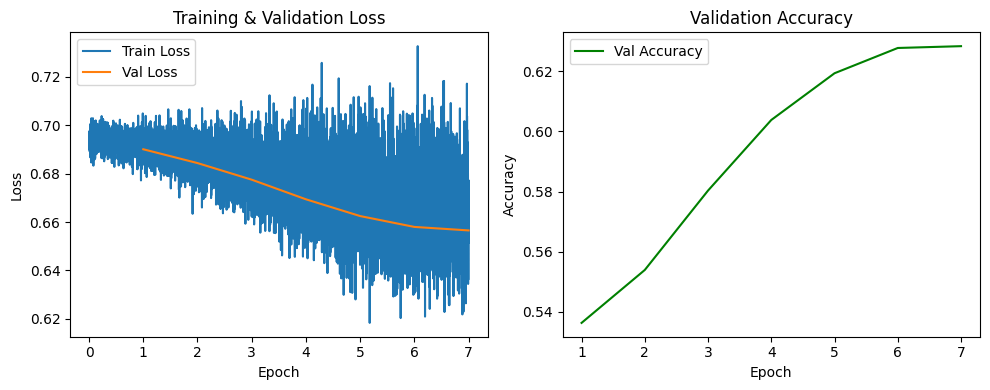

In [ ]:
import matplotlib.pyplot as plt

# Rebuild per-epoch metrics from logs
train_epochs = []
train_losses = []

val_epochs = []
val_losses = []
val_accs = []

for entry in trainer.state.log_history:
    if "loss" in entry and "epoch" in entry:
        train_epochs.append(entry["epoch"])
        train_losses.append(entry["loss"])
    if "eval_loss" in entry:
        val_epochs.append(entry["epoch"])
        val_losses.append(entry["eval_loss"])
    if "eval_accuracy" in entry:
        val_accs.append(entry["eval_accuracy"])

# Plot
plt.figure(figsize=(10, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_epochs, train_losses, label="Train Loss")
plt.plot(val_epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(val_epochs, val_accs, label="Val Accuracy", color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
user_df_ids = set(user_df["id"].tolist())
user_tweet_ids = set(user_tweets.keys())

overlap = user_df_ids.intersection(user_tweet_ids)
print(f"Number of user IDs in both user_df and user_tweets: {len(overlap)}")


Number of user IDs in both user_df and user_tweets: 100000


In [ ]:
sample = train_dataset[0]
print(sample.keys())

dict_keys(['input_ids', 'attention_mask', 'numeric_features', 'clip_features', 'labels'])


In [ ]:
print(train_dataset[0])


{'input_ids': tensor([    0, 45787,  7623,  4540,  3829, 13881,     6,  1614,  6902,     6,
         3562,   142,    38,   437,  4736,     4,  6871,   181,    73,    90,
          285, 20667,    95,   657, 12575, 12363,     4,  1308, 25612,   600,
            4,  1333,    16,    10, 12320,     9,   305,  5223,  2923,  7272,
            4, 10541,   787, 38067,  2459,  4741,   261,    35,   230,   877,
         2091, 13706,  5967,    15,   272,  4894,  7559,  5112,    17,    27,
           29,  5184,    16,     5,   275,   112,     4,  8306,     9,  6338,
           17,    27,    29,  4692,  3266,     8,   132,     4,     5,   275,
          714,  1761,   226,  1174, 10541,   787,  1864, 34054,   895,    35,
        31778,  7446,    11,    84,  5794,     4, 10400,  2553,    31,  9020,
          562,    39,  1109, 19978,   241,    66,  3422,   359,  3914,   131,
         2239,     5, 15154,     9,     5,   721,    31,  1456,  1174, 10541,
          787, 39566,  2802, 32265,  5606,    35, 

In [ ]:
print(val_dataset[0])


{'input_ids': tensor([    0,   487,   605, 35180,   462,  1215, 28693,  2492, 33881, 19556,
        30432, 10772, 31718,     9,  8103, 14285, 12736,   849, 28693,  2492,
        33881,    13,    70,  1721,   849, 24430, 26698,  1721, 10153,     9,
          204,   849, 15048,  1215, 24430,  4207,   359,  6966,    29,  2055,
          787, 38186,  4550,  3917,  8367,  1809,  8103,  6382,  4958,  6569,
         6382, 18400,  6569,  6382, 10278,  6569,  6382,  3070,   849,  9433,
         1215,   506,  5107,  8103,  6382, 11582,  6569,  6382, 18400,  1721,
        26964, 13859,   387,     4,   104,     4,   574,     4, 10541,   787,
          846,  3961,  1075,  2013,   354,    35,    20, 11965,  3366,  8103,
        10470,  6800,  6569, 14285, 27969, 50118, 45070,   201,    35,  1205,
          640,    90,     4,   876,    73,   438,   246,   438,   352,   510,
          771, 42385,   717, 50118, 10431,   705,  3961,  1075,  2013,   354,
          849,   705,  3961,  1075,  2013,   354, 

In [ ]:
# Evaluate on test set
test_results = trainer.evaluate(test_dataset)

print("\nTest Evaluation Results:")
for key, value in test_results.items():
    print(f"{key}: {value}")


Test Evaluation Results:
eval_loss: 0.6564902067184448
eval_accuracy: 0.6305333333333333
eval_runtime: 131.1005
eval_samples_per_second: 114.416
eval_steps_per_second: 14.302
epoch: 7.0



🔍 Classification Report (Default Threshold = 0.5):
              precision    recall  f1-score   support

       human       0.65      0.57      0.60      7500
         bot       0.62      0.70      0.65      7500

    accuracy                           0.63     15000
   macro avg       0.63      0.63      0.63     15000
weighted avg       0.63      0.63      0.63     15000


Macro F1 Score: 0.6289
Weighted F1 Score: 0.6289


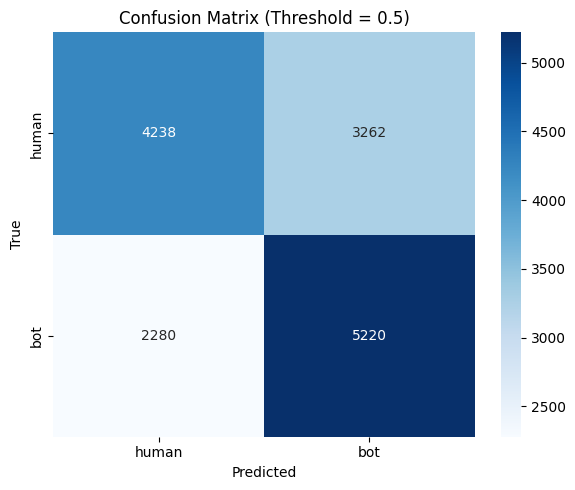


🔧 Threshold tuning results (based on softmax bot probability):

Threshold = 0.3
              precision    recall  f1-score   support

       human       0.87      0.02      0.03      7500
         bot       0.50      1.00      0.67      7500

    accuracy                           0.51     15000
   macro avg       0.69      0.51      0.35     15000
weighted avg       0.69      0.51      0.35     15000


Threshold = 0.4
              precision    recall  f1-score   support

       human       0.74      0.16      0.26      7500
         bot       0.53      0.95      0.68      7500

    accuracy                           0.55     15000
   macro avg       0.64      0.55      0.47     15000
weighted avg       0.64      0.55      0.47     15000


Threshold = 0.45
              precision    recall  f1-score   support

       human       0.71      0.31      0.44      7500
         bot       0.56      0.87      0.68      7500

    accuracy                           0.59     15000
   macro avg

In [ ]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix, precision_recall_fscore_support
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Predictions and true labels
predictions = trainer.predict(test_dataset)
logits = predictions.predictions
true_labels = predictions.label_ids

# Default threshold (argmax)
pred_labels = np.argmax(logits, axis=-1)

print("\n🔍 Classification Report (Default Threshold = 0.5):")
print(classification_report(
    true_labels,
    pred_labels,
    labels=[0, 1],
    target_names=["human", "bot"],
    zero_division=0
))

# Macro and weighted F1 scores
macro_f1 = f1_score(true_labels, pred_labels, average='macro')
weighted_f1 = f1_score(true_labels, pred_labels, average='weighted')
print(f"\nMacro F1 Score: {macro_f1:.4f}")
print(f"Weighted F1 Score: {weighted_f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels, labels=[0, 1])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["human", "bot"],
            yticklabels=["human", "bot"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Threshold = 0.5)")
plt.tight_layout()
plt.show()

# 🔧 Threshold tuning
print("\n🔧 Threshold tuning results (based on softmax bot probability):")
probs = torch.nn.functional.softmax(torch.tensor(logits), dim=1)[:, 1]  # prob of bot
thresholds = [0.3, 0.4, 0.45, 0.5, 0.55, 0.6]

for t in thresholds:
    pred_thresh = (probs > t).long().numpy()
    print(f"\nThreshold = {t}")
    print(classification_report(
        true_labels,
        pred_thresh,
        labels=[0, 1],
        target_names=["human", "bot"],
        zero_division=0
    ))


In [ ]:
label_df = pd.read_csv(os.path.join(data_dir, "label.csv"))
label_counts = label_df['label'].value_counts()
print(label_counts)


label
human    860057
bot      139943
Name: count, dtype: int64


In [ ]:
labeled_ids = set(label_dict.keys())
split_train_ids = {uid for uid, split in split_dict.items() if split == "train"}
tweet_user_ids = set(user_tweets.keys())
user_ids_loaded = set(user_df["id"])

# Check overlap
final_train_pool = user_ids_loaded & labeled_ids & split_train_ids & tweet_user_ids
print(f"Final trainable user pool size: {len(final_train_pool)}")

# Check bot/human balance
bot_count = sum(1 for uid in final_train_pool if label_dict[uid] == "bot")
human_count = sum(1 for uid in final_train_pool if label_dict[uid] == "human")
print(f"Trainable pool - Bots: {bot_count}, Humans: {human_count}")


Final trainable user pool size: 70000
Trainable pool - Bots: 35000, Humans: 35000


**Visualizing the Model:**

In [ ]:
from torchsummary import summary

# Install if not available
!pip install torchsummary

# Move model to appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Use dummy inputs that match your model's expected inputs
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("roberta-base")
dummy_input = tokenizer("hello world", return_tensors="pt", padding="max_length", max_length=512)
input_ids = dummy_input["input_ids"].to(device)
attention_mask = dummy_input["attention_mask"].to(device)

numeric_features = torch.rand((1, 4)).to(device)       # 4 behavioral features
clip_features = torch.rand((1, 512)).to(device)         # 512-dim CLIP features
labels = torch.tensor([1]).to(device)                  # example label

# Forward pass to check dimensions
with torch.no_grad():
    output = model(input_ids=input_ids,
                   attention_mask=attention_mask,
                   numeric_features=numeric_features,
                   clip_features=clip_features,
                   labels=labels)

print("Model forward pass complete")
print("Output keys:", output.keys())


Model forward pass complete
Output keys: dict_keys(['loss', 'logits'])


In [ ]:
# Install torchviz if not already installed
!pip install torchviz

# Imports
import torch
from torchviz import make_dot
from transformers import AutoTokenizer

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

# Create dummy inputs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

dummy_text = "This is a test input for the model."
encoded = tokenizer(dummy_text, return_tensors="pt", padding="max_length", max_length=512, truncation=True)
input_ids = encoded["input_ids"].to(device)
attention_mask = encoded["attention_mask"].to(device)

numeric_features = torch.rand((1, 4)).to(device)      # 4 behavioral features
clip_features = torch.rand((1, 512)).to(device)       # 512-dim CLIP features
labels = torch.tensor([1]).to(device)                 # dummy label

# Forward pass (with graph)
output = model(input_ids=input_ids,
               attention_mask=attention_mask,
               numeric_features=numeric_features,
               clip_features=clip_features,
               labels=labels)

# Visualize the computation graph
make_dot(output["loss"], params=dict(model.named_parameters())).render("model_graph", format="png")

# Downloadable or viewable as 'model_graph.png' in current directory
from PIL import Image
Image.open("model_graph.png").show()


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (94694692 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [ ]:
!pip install torchview

import torch
import torch.nn as nn
from torchview import draw_graph

# Wrapper class to make torchview work
class VisualWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x1, x2, x3, x4):
        return self.model(
            input_ids=x1,
            attention_mask=x2,
            numeric_features=x3,
            clip_features=x4
        )

# Prepare model
model_cpu = model.to("cpu")
model_cpu.eval()
wrapped_model = VisualWrapper(model_cpu)

# Dummy input data
dummy_input_ids = torch.ones((1, 256), dtype=torch.long)
dummy_attention_mask = torch.ones((1, 256), dtype=torch.long)
dummy_numeric = torch.rand((1, 4))
dummy_clip = torch.rand((1, 512))

# Draw graph
graph = draw_graph(
    wrapped_model,
    input_data=(dummy_input_ids, dummy_attention_mask, dummy_numeric, dummy_clip),
    expand_nested=True,
    save_graph=True,
    filename="simple_model_architecture"
)

# ✅ Display graph
graph  # This renders the graph in Colab


In [ ]:
torch.save(model, "final_model_full.pt")  # full model
